**CODE IMPLEMENTATION OF DAS FOR ULTRASOUND IMAGE RECONSTRUCTION**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

**Initializing the microphone location array**

In [2]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)

# Spacing between microphones
pitch = 0.1

# start and end Locations of microphones
# The start location is shifted by 0.05 (pitch/2) so as to maintain symmetric distribution of 64 microphones around the origin
start = 0.05 - pitch*Nmics/2  
end = pitch*Nmics/2

# Generate y-coordinates with fixed separation
y_coords = np.arange(start, end, 0.1)

# Generate (x, y) pairs
mics = np.column_stack((np.zeros_like(y_coords), y_coords))


**Generating the Source Sinc Pulse**

In [3]:
# proxy for sampling rate
dist_per_samp = 0.1

# Speed of sound in the medium
C = 2.0

# Time dilation factor for sinc pulse: how narrow
SincP = 5.0

t = np.arange(0, Nsamp * dist_per_samp, dist_per_samp)

# Define source waveform
def wsrc(t):
    return np.sinc(SincP * (t))

source_wave = wsrc(t)

**Calculating Total Distance travelled by the wave from source to a point and back**

In [4]:
# Distance function with reflection through an obstacle
def dist(src, pt, mic):
    d1 = math.dist(src, pt)# Distance from source to obstacle
    d2 = math.dist(pt, mic) # Distance from obstacle to mic
    return d1 + d2

**Obstacle Location**

In [5]:
obstacle = (3,-1)

**Plot of the Microphone Outputs for given obstacle location**

Text(0, 0.5, 'Mic Location')

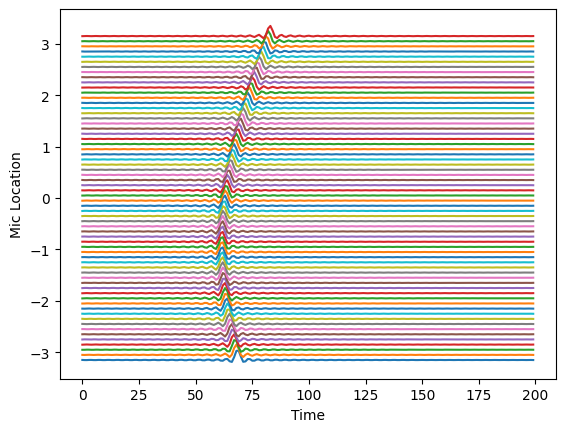

In [6]:
plt.figure()
for mic in mics:
    #generate the sinc pulse for each mic
    amp = wsrc(t-dist(src,obstacle,mic))*0.2
    #shift the plot by the y_coordinate of the mics to get the output for every mic location with appropriate spacing
    plt.plot(amp+mic[1])
plt.xlabel("Time")
plt.ylabel("Mic Location")

**Heatmap plot for the same**

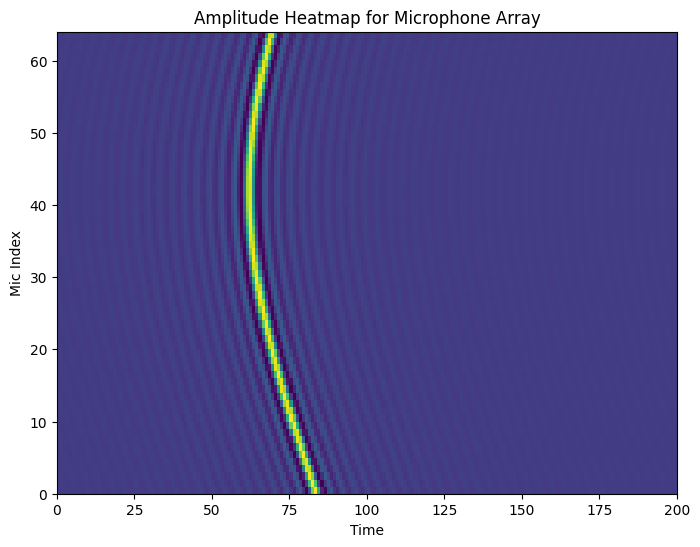

In [7]:
heatmap = np.zeros((Nmics, Nsamp))

for i, mic in enumerate(mics):
    # Calculate the amplitude for each mic based on its distance from the source
    amp = wsrc(t - dist(src, obstacle, mic)) 
    heatmap[i, :] = amp  # Store the calculated amplitude for each mic

# Now plot this data as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, aspect='auto', cmap='viridis', extent=[0, Nsamp, 0, Nmics])
plt.xlabel("Time")
plt.ylabel("Mic Index")
plt.title("Amplitude Heatmap for Microphone Array")
plt.show()


**Calculation of Microphone Outputs for obstacle at given location**

In [8]:
mic_outputs = np.zeros((Nmics, Nsamp))
for i, mic in enumerate(mics):
    total_dist = dist(src, obstacle, mic) /C
    delay_samples = int(total_dist/ dist_per_samp) # Calculate delay in samples
    
    # Check if the delay is within the valid range
    if delay_samples < Nsamp:
        # Shift the source wave for the delay and assign to microphone output
        mic_outputs[i, delay_samples:] = source_wave[:Nsamp - delay_samples]

**Reconstruction of obstacle image from generated microphone outputs**

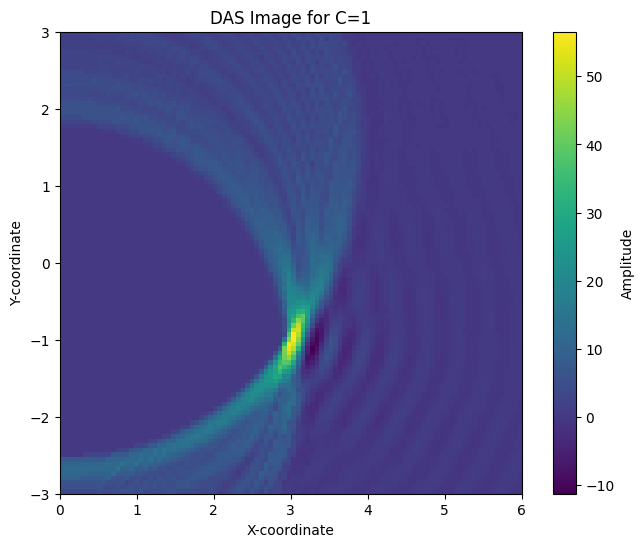

In [9]:
x_grid, y_grid = np.linspace(0, 6, 100), np.linspace(-3, 3, 100)
das_images = []

das_image = np.zeros((len(y_grid), len(x_grid)))

for xi, x in enumerate(x_grid):
    for yi, y in enumerate(y_grid):
        total_signal = 0
        for mic_index, mic in enumerate(mics):
            # Calculate expected delay based on distance from (x, y) to mic
            delay = int(((dist(src, (x, y), mic)/C) /dist_per_samp))

            # Ensure delay is within the valid range of indices
            if 0 <= delay < 200: 
                total_signal += mic_outputs[mic_index, delay]

        das_image[yi, xi] = total_signal

# Store and plot the DAS image
das_images.append(das_image)
plt.figure(figsize=(8, 6))
plt.imshow(das_image, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("DAS Image for C=1")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()


**Load in Data from the given files**

In [10]:
array1 = np.loadtxt('rx2.txt')
array2 = np.loadtxt('rx3.txt')

**Reconstruction of the obstacle locations using DAS**

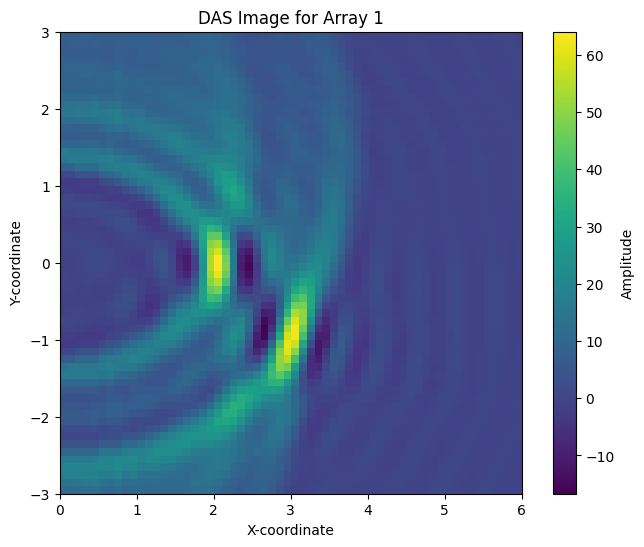

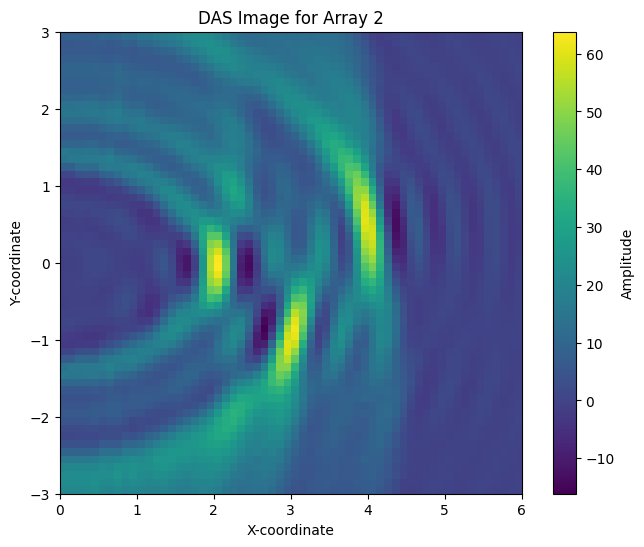

In [11]:
x_grid, y_grid = np.linspace(0, 6, 60), np.linspace(-3, 3, 60)
das_images = []

for i, mic_data in enumerate([array1, array2], start=1):
    das_image = np.zeros((len(y_grid), len(x_grid)))
    
    for xi, x in enumerate(x_grid):
        for yi, y in enumerate(y_grid):
            total_signal = 0
            for mic_index, mic in enumerate(mics):
                # Calculate expected delay based on distance from (x, y) to mic
                delay = int((dist(src, (x, y), mic)) / dist_per_samp)

                # Ensure delay is within the valid range of indices
                if 0 <= delay < Nsamp:
                    total_signal += mic_data[mic_index, delay]

            das_image[yi, xi] = total_signal

    # Store and plot DAS image for each array
    das_images.append(das_image)
    plt.figure(figsize=(8, 6))
    plt.imshow(das_image, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]], origin='lower', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title(f"DAS Image for Array {i}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.show()


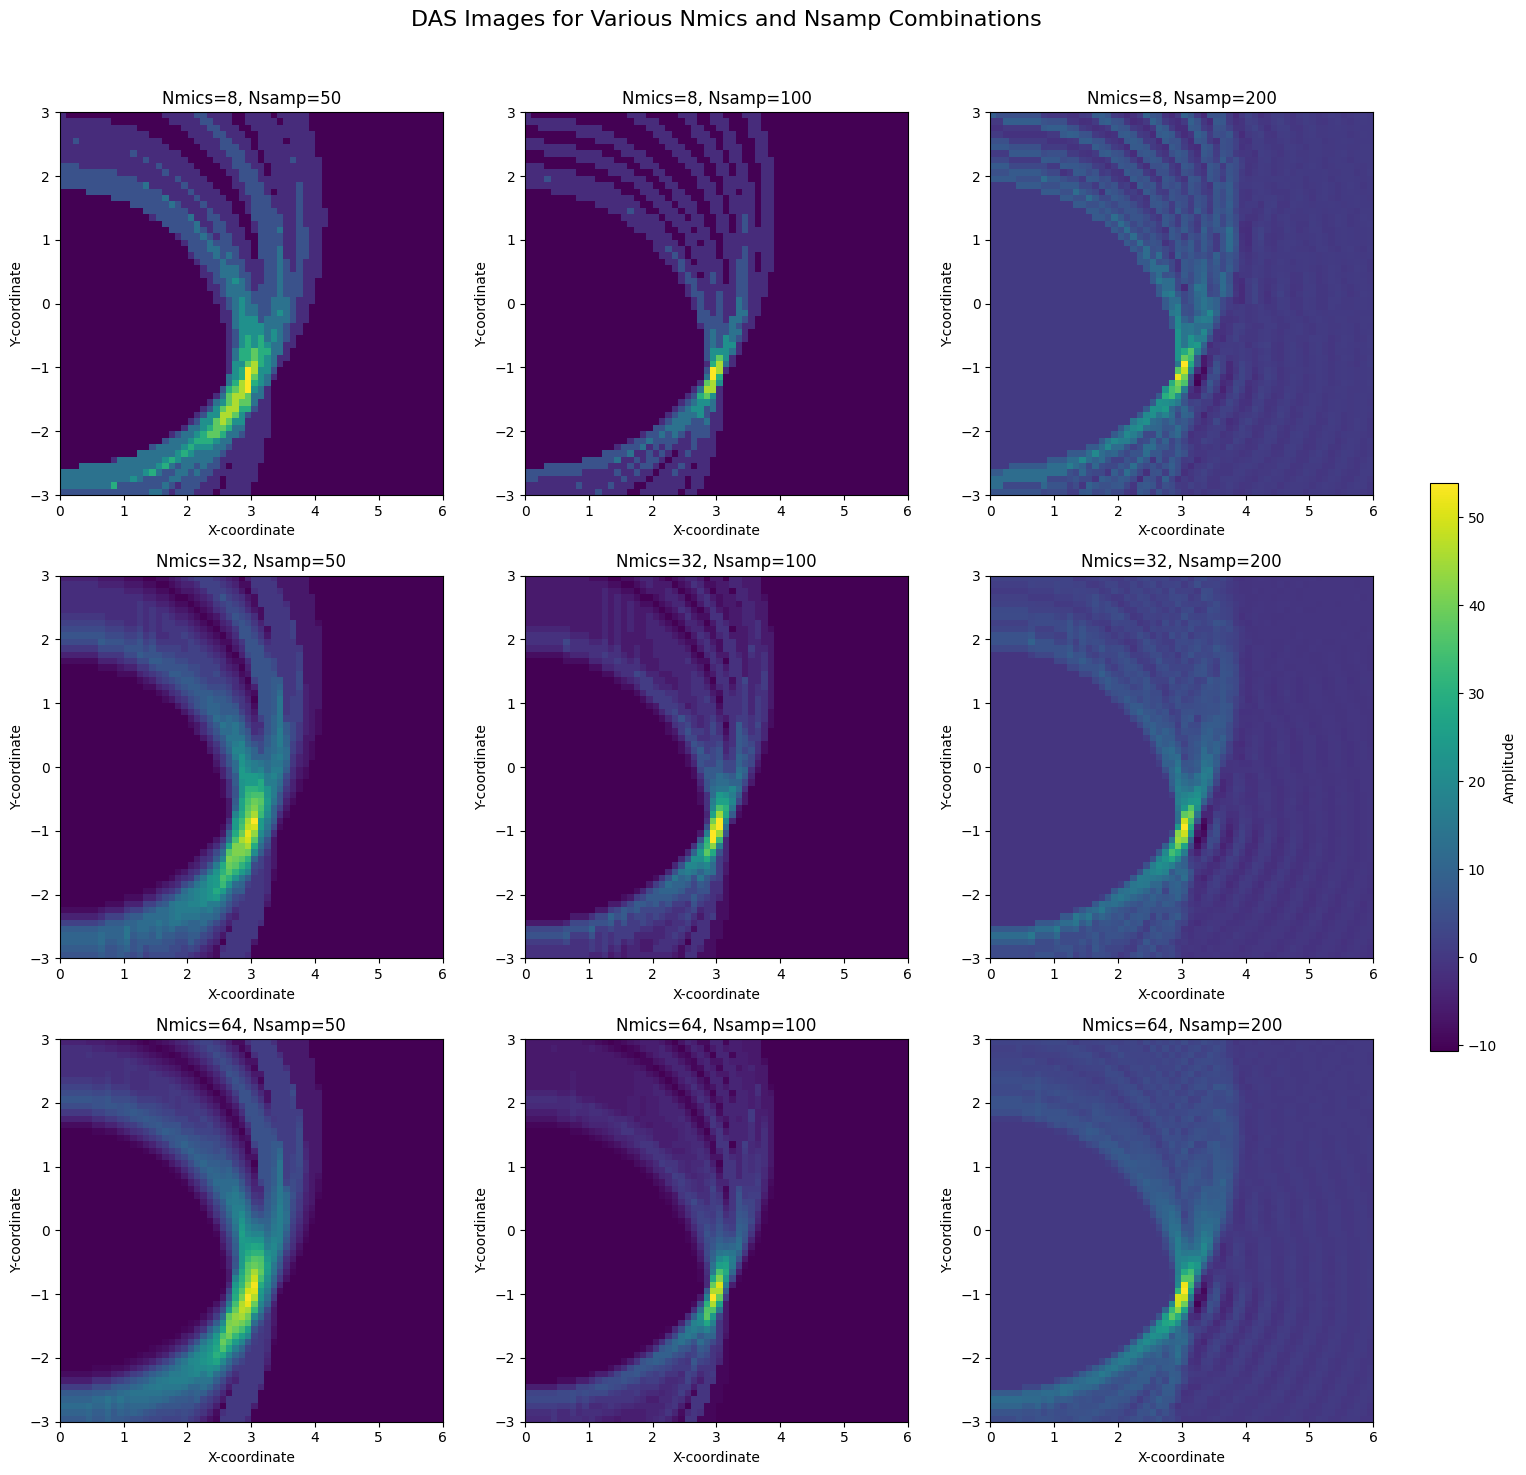

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume these are defined:
# dist: distance function
# wsrc: sinc pulse generation function
# C: speed of sound
# dist_per_samp: calculated based on C and sampling rate

N_mics_values = [8, 32, 64]
N_samp_values = [50, 100, 200]
dist_per_samp = 0.1  # Example value, should be calculated based on C and sampling rate

# Initialize plot with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("DAS Images for Various Nmics and Nsamp Combinations", fontsize=16)

for row, Nmics in enumerate(N_mics_values):
    for col, Nsamp in enumerate(N_samp_values):
        ax = axes[row, col]
        
        # Set source and obstacle positions
        src = (0, 0)
        C = 2.0
        obstacle = (3, -1)
        dist_per_samp = 20 / Nsamp  # Adjusted for each Nsamp

        # Calculate pitch and microphone positions
        pitch = 6.4 / Nmics
        start = pitch / 2 - pitch * Nmics / 2
        end = pitch * Nmics / 2
        y_coords = np.arange(start, end, pitch)
        mics = np.column_stack((np.zeros_like(y_coords), y_coords))
        t = np.arange(0, Nsamp * dist_per_samp, dist_per_samp)

        # Initialize microphone outputs
        mic_outputs = np.zeros((Nmics, Nsamp))

        # Calculate delayed signals for each microphone
        for i, mic in enumerate(mics):
            total_dist = dist(src, obstacle, mic) / C
            delay_samples = int(total_dist / dist_per_samp)
            if delay_samples < Nsamp:
                mic_outputs[i, delay_samples:] = wsrc(t[:Nsamp - delay_samples])

        # Generate DAS image
        x_grid, y_grid = np.linspace(0, 6, 60), np.linspace(-3, 3, 60)
        das_image = np.zeros((len(y_grid), len(x_grid)))

        for xi, x in enumerate(x_grid):
            for yi, y in enumerate(y_grid):
                total_signal = 0
                for mic_index, mic in enumerate(mics):
                    delay = int((dist(src, (x, y), mic) / C) / dist_per_samp)
                    if 0 <= delay < Nsamp:
                        total_signal += mic_outputs[mic_index, delay]
                das_image[yi, xi] = total_signal

        # Plot each DAS image in the respective subplot
        im = ax.imshow(das_image, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
                       origin='lower', cmap='viridis')
        ax.set_title(f"Nmics={Nmics}, Nsamp={Nsamp}")
        ax.set_xlabel("X-coordinate")
        ax.set_ylabel("Y-coordinate")

# Adjust layout and add color bar
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("Amplitude")

plt.show()
